# Google Play APP 评分分类

In [2]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import warnings

warnings.filterwarnings("ignore")
# % matplotlib inline

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# 1. 数据读取

In [4]:
df = pd.read_csv("D://DataModel//Google_Play_Store//reviews.csv")
df = df.head(1000)
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,gp:AOqpTOG-nGuDe0w6if400pTvNJnK3MlfnEcJLIB84aR...,Ben Maybe,https://play-lh.googleusercontent.com/a/AATXAJ...,But the paid version for a year and never succ...,1,25,5.15.4.2,2022-03-01 17:18:50,"Hi, we're sorry to hear you're experiencing is...",2022-03-01 15:53:58,most_relevant,com.anydo
1,gp:AOqpTOH85sc18Ajgcgj6-IGmA7Gp34fVsrbyBJ274IZ...,Anthony Duarte,https://play-lh.googleusercontent.com/a-/AOh14...,"As a programmer, this is absolutely the most l...",1,67,5.15.3.0,2022-01-22 11:33:48,We are sorry you feel this way! We encourage u...,2022-01-24 09:59:17,most_relevant,com.anydo
2,gp:AOqpTOGxyMqOStnhbQ_mLfnLUfd1DHAt5uRXqDNArML...,Through Genesis,https://play-lh.googleusercontent.com/a/AATXAJ...,Redoing my review after messaging with the app...,1,77,5.15.3.0,2022-01-22 13:34:47,"Any.do is a free app, 90% of the app is comple...",2022-01-24 09:58:12,most_relevant,com.anydo
3,gp:AOqpTOE3fQQpkWOMbSHW-DwukAnILBbMwBHEcbReiit...,Sydney Stoll,https://play-lh.googleusercontent.com/a/AATXAJ...,I have had this app for almost a year. I was r...,1,79,5.15.2.1,2021-11-07 15:58:27,This could happen if a user pressed on an adve...,2021-11-08 14:36:27,most_relevant,com.anydo
4,gp:AOqpTOG2AXuKqrR8FIN43a5BGZY4Iha5SFQZZ6o9vOR...,ChuCannon,https://play-lh.googleusercontent.com/a/AATXAJ...,"Works decently most of the time, but I've noti...",1,39,5.15.2.2,2021-11-18 17:05:38,"Hi, we're sorry to hear you're experiencing is...",2021-11-21 14:48:23,most_relevant,com.anydo


## 1.1 可视化分析

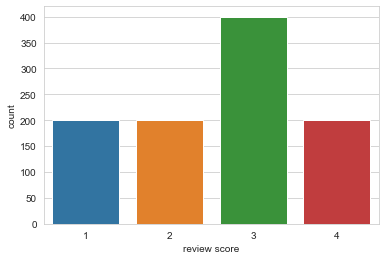

In [5]:
sns.countplot(df.score)
plt.xlabel('review score');

## 1.2情感按评分分3类

In [6]:
def sentiment(rating):
    if rating < 2:
        return 0

    if rating == 3:
        return 1

    if rating > 3:
        return 2


df['sentiment'] = df.score.apply(sentiment)
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId,sentiment
0,gp:AOqpTOG-nGuDe0w6if400pTvNJnK3MlfnEcJLIB84aR...,Ben Maybe,https://play-lh.googleusercontent.com/a/AATXAJ...,But the paid version for a year and never succ...,1,25,5.15.4.2,2022-03-01 17:18:50,"Hi, we're sorry to hear you're experiencing is...",2022-03-01 15:53:58,most_relevant,com.anydo,0.0
1,gp:AOqpTOH85sc18Ajgcgj6-IGmA7Gp34fVsrbyBJ274IZ...,Anthony Duarte,https://play-lh.googleusercontent.com/a-/AOh14...,"As a programmer, this is absolutely the most l...",1,67,5.15.3.0,2022-01-22 11:33:48,We are sorry you feel this way! We encourage u...,2022-01-24 09:59:17,most_relevant,com.anydo,0.0
2,gp:AOqpTOGxyMqOStnhbQ_mLfnLUfd1DHAt5uRXqDNArML...,Through Genesis,https://play-lh.googleusercontent.com/a/AATXAJ...,Redoing my review after messaging with the app...,1,77,5.15.3.0,2022-01-22 13:34:47,"Any.do is a free app, 90% of the app is comple...",2022-01-24 09:58:12,most_relevant,com.anydo,0.0
3,gp:AOqpTOE3fQQpkWOMbSHW-DwukAnILBbMwBHEcbReiit...,Sydney Stoll,https://play-lh.googleusercontent.com/a/AATXAJ...,I have had this app for almost a year. I was r...,1,79,5.15.2.1,2021-11-07 15:58:27,This could happen if a user pressed on an adve...,2021-11-08 14:36:27,most_relevant,com.anydo,0.0
4,gp:AOqpTOG2AXuKqrR8FIN43a5BGZY4Iha5SFQZZ6o9vOR...,ChuCannon,https://play-lh.googleusercontent.com/a/AATXAJ...,"Works decently most of the time, but I've noti...",1,39,5.15.2.2,2021-11-18 17:05:38,"Hi, we're sorry to hear you're experiencing is...",2021-11-21 14:48:23,most_relevant,com.anydo,0.0


[Text(0, 0, 'negative'), Text(1, 0, 'neutral'), Text(2, 0, 'positive')]

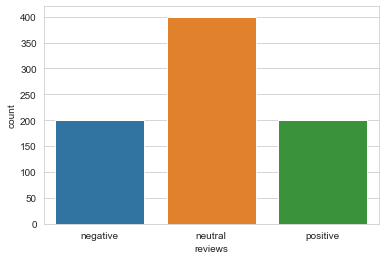

In [7]:
ax = sns.countplot(df.sentiment)
plt.xlabel('reviews')
ax.set_xticklabels(['negative', 'neutral', 'positive'])

# 2. 定义Tokenizer 和 Datasets

In [8]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

tokenizer = BertTokenizer.from_pretrained(pretrained_model_name_or_path=PRE_TRAINED_MODEL_NAME)

## 2.1 tokenizer 试用，特殊token

In [9]:
# sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'
# tokens = tokenizer.tokenize(sample_txt)
# token_ids = tokenizer.encode(sample_txt)
# token_ids
print('[SEP]:',tokenizer.sep_token,tokenizer.sep_token_id)
print('[CLS]:',tokenizer.cls_token,tokenizer.cls_token_id)
print('[PAD]:',tokenizer.pad_token,tokenizer.pad_token_id)

[SEP]: [SEP] 102
[CLS]: [CLS] 101
[PAD]: [PAD] 0


## 2.2 显示句子长度分布

Text(0.5, 0, 'Token count')

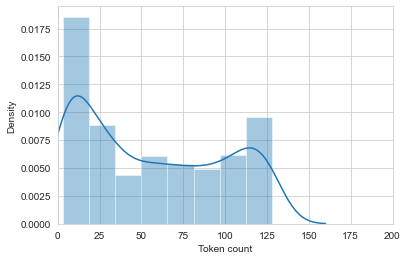

In [10]:
token_lens = []

for text in df.content:
    tokens = tokenizer.encode(text,truncation=True, max_length=128)
    token_lens.append(len(tokens))

sns.distplot(token_lens)
plt.xlim([0, 200])
plt.xlabel('Token count')

In [11]:
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'
encoding = tokenizer.encode_plus(
    sample_txt,
    max_length = 32,
    add_special_tokens = True, # [CLS] and [SEP]
    pad_to_max_length = True,
    return_token_type_ids = False,
    return_attention_mask = True,
    return_tensors = 'pt' # pt for pytorch
)
print(encoding)
print(tokenizer.decode(encoding['input_ids'][0]))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


{'input_ids': tensor([[ 101, 1332, 1108,  146, 1314, 1796,  136,  146, 1821, 5342, 1120, 1313,
         1111,  123, 2277,  119,  102,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])}
[CLS] When was I last outside? I am stuck at home for 2 weeks. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


## 2.3 创建 Datasets

In [12]:
class CustomDataset(Dataset):
    def __init__(self, reviews, targets, tokenizer, max_len):
        super().__init__()
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self,item):
        review = self.reviews[item]
        target = self.targets[item]

        encoding = tokenizer.encode_plus(
            review,
            max_length = self.max_len,
            add_special_tokens = True,
            pad_to_max_length = True,
            return_token_type_ids = False,
            return_attention_mask = True,
            return_tensors = 'pt'
        )

        return {
            'review': review,
            'target': torch.tensor(target,dtype=torch.long),
            'input_ids': encoding['input_ids'].flatten(),
            # attention_mask: [pad] 的位置是0,其他位置是1
            'attention_mask': encoding['attention_mask'].flatten()
        }

In [13]:
df.shape
df = df[df['sentiment'].notna()]
df.isnull().sum()

reviewId                  0
userName                  0
userImage                 0
content                   0
score                     0
thumbsUpCount             0
reviewCreatedVersion    139
at                        0
replyContent             83
repliedAt                83
sortOrder                 0
appId                     0
sentiment                 0
dtype: int64

In [14]:
MAX_LEN = 160
BATCH_SIZE = 6
RANDOM_SEED = 2002
EPOCHS = 10

In [15]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [16]:
df_train.shape, df_test.shape, df_val.shape

((640, 13), (80, 13), (80, 13))

In [17]:
ds = CustomDataset(
    reviews=df.content.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

In [18]:
def Data_Loader(df, tokenizer, max_len, batch_size):
    ds = CustomDataset(
        reviews=df.content.to_numpy(),
        targets=df.sentiment.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )

    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=4
    )

In [19]:
train_data_loader = Data_Loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = Data_Loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = Data_Loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [20]:
# for data in train_data_loader:
#     print(data)
#     break
#
# print(data['input_ids'].shape)
# print(data['attention_mask'].shape)
# print(data['target'].shape)


# 3. Bert 预训练模型做分类

In [21]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [22]:
last_hidden_state, pooled_output = bert_model(
    input_ids = encoding['input_ids'],
    attention_mask = encoding['attention_mask'],
    return_dict=False
)
print(last_hidden_state.shape)
print(pooled_output.shape)

torch.Size([1, 32, 768])
torch.Size([1, 768])


In [23]:
bert_model.config.hidden_size

768

## 3.1 建立分类模型

In [1]:
class SentimentClassifier(nn.Module):
    def __init__(self,n_classes):
        super().__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.dropout = nn.Dropout(p=0.2)
        self.linear = nn.Linear(self.bert.config.hidden_size, n_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
            input_ids = input_ids,
            attention_mask = attention_mask,
            return_dict = False
        )
        output = self.dropout(pooled_output)
        output = self.linear(output)
        return self.softmax(output)

NameError: name 'nn' is not defined

In [25]:
model = SentimentClassifier(n_classes = 3)
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [26]:
optimizer = AdamW(model.parameters(),lr=2e-5,correct_bias=False)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 0,
    num_training_steps = total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [27]:
def train_model(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_preds = 0

    for data in data_loader:
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        targets = data['target'].to(device)

        outputs = model(input_ids,attention_mask)
        _, preds = torch.max(outputs,dim=1)
        loss = loss_fn(outputs,targets)
        correct_preds += torch.sum(preds==targets)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm(model.parameters(),max_norm=1.0) #  We're avoiding exploding gradients by clipping the gradients of the model using clip_gradnorm.
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_preds.double() / n_examples, np.mean(losses)

In [28]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_preds = 0

    with torch.no_grad():
        for data in data_loader:
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_mask'].to(device)
            targets = data['target'].to(device)

            outputs = model(input_ids,attention_mask)
            _, preds = torch.max(outputs,dim=1)
            loss = loss_fn(outputs,targets)
            correct_preds += torch.sum(preds==targets)
            losses.append(loss.item())

    return correct_preds.double() / n_examples, np.mean(losses)

In [29]:
# history = defaultdict(list)
# best_accuracy = 0
#
# for epoch in range(EPOCHS):
#     print(f'Epoch {epoch + 1}/{EPOCHS}')
#     print('-' * 10)
#
#     train_acc, train_loss = train_model(model,train_data_loader, loss_fn, optimizer, device, scheduler, len(df_train))
#     print(f'Train loss {train_loss} accuracy {train_acc}')
#
#     val_acc, val_loss = eval_model(model, val_data_loader, loss_fn, device, len(df_val))
#     print(f'Val   loss {val_loss} accuracy {val_acc}')
#     print('\n')
#
#     history['train_acc'].append(train_acc)
#     history['train_loss'].append(train_loss)
#     history['val_acc'].append(val_acc)
#     history['val_loss'].append(val_loss)
#
#     if val_acc > best_accuracy:
#         #         torch.save(model.state_dict(),'best_model_state.bin')
#         best_accuracy = val_acc

In [36]:
model = SentimentClassifier(n_classes = 3)
model.load_state_dict(torch.load('model_params.mdl'))
model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


SentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affin

In [37]:
def get_preds(model, data_loader):
    model = model.eval()

    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for data in data_loader:
            reviews = data['review']
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_mask'].to(device)
            targets = data['target'].to(device)

            review_texts.extend(reviews)
            real_values.extend(targets)

            outputs = model(input_ids,attention_mask)
            _, preds = torch.max(outputs,dim=1)

            prediction_probs.extend(outputs)
            predictions.extend(preds)

        predictions = torch.stack(predictions).cpu()
        prediction_probs = torch.stack(prediction_probs).cpu()
        real_values = torch.stack(real_values).cpu()


    return review_texts, predictions, prediction_probs, real_values

In [ ]:
review_texts, predictions, prediction_probs, real_values = get_preds(model,test_data_loader)